In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
merged_df = pd.read_csv('/content/drive/MyDrive/MADS Capstone Team 23/Data/processed/merged_population_crime_homepermit.csv')

In [ ]:
merged_df.columns

Index(['City', 'Date', 'ZHVI', 'NewHomePermits', 'Population_In_Housing_Units',
       'Owner_Occupied_Population', 'Renter-Occupied-Population',
       'OOP_Moved_From_Different_County', 'OOP_Moved_From_Different_State',
       'OOP_Moved_From_Abroad', 'ROP_Moved_From_Different_County',
       'ROP_Moved_From_Different_State', 'ROP_Moved_From_Abroad',
       'PropertyCrimeIncident', 'ViolentCrimeIncident'],
      dtype='object')

## Test If Less feature gives better performance

In [ ]:
mse_results_with_more_features = {
    "Chicago":438524896.00,
    "Dallas": 5695424993.75,
    "Los Angeles": 118862908150.16,
    "New York": 8119322944.72,
    "Seattle": 42481872419.60
}

In [ ]:
# Function to process the data
def preprocess_data(df, window=12):
    # Separate train and test data (80% train, 20% test)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    # Create sequences of 12 months for training
    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

In [ ]:
fewer_df = merged_df.drop(columns=['OOP_Moved_From_Different_County', 'OOP_Moved_From_Different_State',
       'OOP_Moved_From_Abroad', 'ROP_Moved_From_Different_County',
       'ROP_Moved_From_Different_State', 'ROP_Moved_From_Abroad'])

In [ ]:
fewer_df.head()

,City,Date,ZHVI,NewHomePermits,Population_In_Housing_Units,Owner_Occupied_Population,Renter-Occupied-Population,PropertyCrimeIncident,ViolentCrimeIncident
0,Chicago,2010-01-01,201888.606600,345.0,9206524,6353379,2853145,14429.0,8335.0
1,Chicago,2010-02-01,201527.551140,370.0,9208651,6351028,2857623,11584.0,7056.0
2,Chicago,2010-03-01,200518.003420,561.0,9210778,6348678,2862100,15265.0,9819.0
3,Chicago,2010-04-01,200674.643669,543.0,9212906,6346328,2866578,15354.0,9834.0
4,Chicago,2010-05-01,200205.154396,924.0,9215033,6343977,2871056,16297.0,10654.0


In [ ]:
X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}
scalers = {}
models = {}
lstm_preds = {}
actual_vals = {}
mse_results_with_fewer_features = {}

for city in fewer_df['City'].unique():
    city_data = fewer_df[fewer_df['City'] == city].reset_index(drop=True)
    X_train_dict[city], y_train_dict[city], X_test_dict[city], y_test_dict[city], scalers[city] = preprocess_data(city_data)
    models[city] = create_and_train_lstm(X_train_dict[city], y_train_dict[city])
    lstm_preds[city] = make_predictions(models[city], X_test_dict[city], scalers[city])
    actual_vals[city] = scalers[city].inverse_transform(np.hstack((y_test_dict[city].reshape(-1, 1), np.zeros((y_test_dict[city].shape[0], X_test_dict[city].shape[2] - 1)))))
    actual_vals[city] = actual_vals[city][:, 0]  # Only return the ZHVI actuals
    mse = mean_squared_error(actual_vals[city], lstm_preds[city])
    mse_results_with_fewer_features[city] = mse
    print(f'{city} - LSTM Model MSE: {mse:.2f}')

Epoch 1/100
3/3 [==============================] - 13s 754ms/step - loss: 0.1859 - val_loss: 0.4378
Epoch 2/100
3/3 [==============================] - 0s 34ms/step - loss: 0.0611 - val_loss: 0.1744
Epoch 3/100
3/3 [==============================] - 0s 48ms/step - loss: 0.0672 - val_loss: 0.1329
Epoch 4/100
3/3 [==============================] - 0s 36ms/step - loss: 0.0573 - val_loss: 0.1767
Epoch 5/100
3/3 [==============================] - 0s 35ms/step - loss: 0.0355 - val_loss: 0.2402
Epoch 6/100
3/3 [==============================] - 0s 44ms/step - loss: 0.0313 - val_loss: 0.2619
Epoch 7/100
3/3 [==============================] - 0s 37ms/step - loss: 0.0285 - val_loss: 0.2075
Epoch 8/100
3/3 [==============================] - 0s 33ms/step - loss: 0.0171 - val_loss: 0.1140
Epoch 9/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0090 - val_loss: 0.0464
Epoch 10/100
3/3 [==============================] - 0s 35ms/step - loss: 0.0082 - val_loss: 0.0253
Epoch 11/100
3/3 

1/1 [==============================] - 1s 1s/step
Chicago - LSTM Model MSE: 237474074.98
Epoch 1/100
3/3 [==============================] - 7s 593ms/step - loss: 0.0364 - val_loss: 0.0123
Epoch 2/100
3/3 [==============================] - 0s 47ms/step - loss: 0.0175 - val_loss: 0.0012
Epoch 3/100
3/3 [==============================] - 0s 41ms/step - loss: 0.0037 - val_loss: 0.0338
Epoch 4/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0076 - val_loss: 0.0343
Epoch 5/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 6/100
3/3 [==============================] - 0s 39ms/step - loss: 0.0021 - val_loss: 3.6567e-04
Epoch 7/100
3/3 [==============================] - 0s 45ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 8/100
3/3 [==============================] - 0s 47ms/step - loss: 8.7542e-04 - val_loss: 0.0218
Epoch 9/100
3/3 [==============================] - 0s 42ms/step - loss: 0.0014 - val_loss: 0.0252
Epoch 10/100
3/3 [==

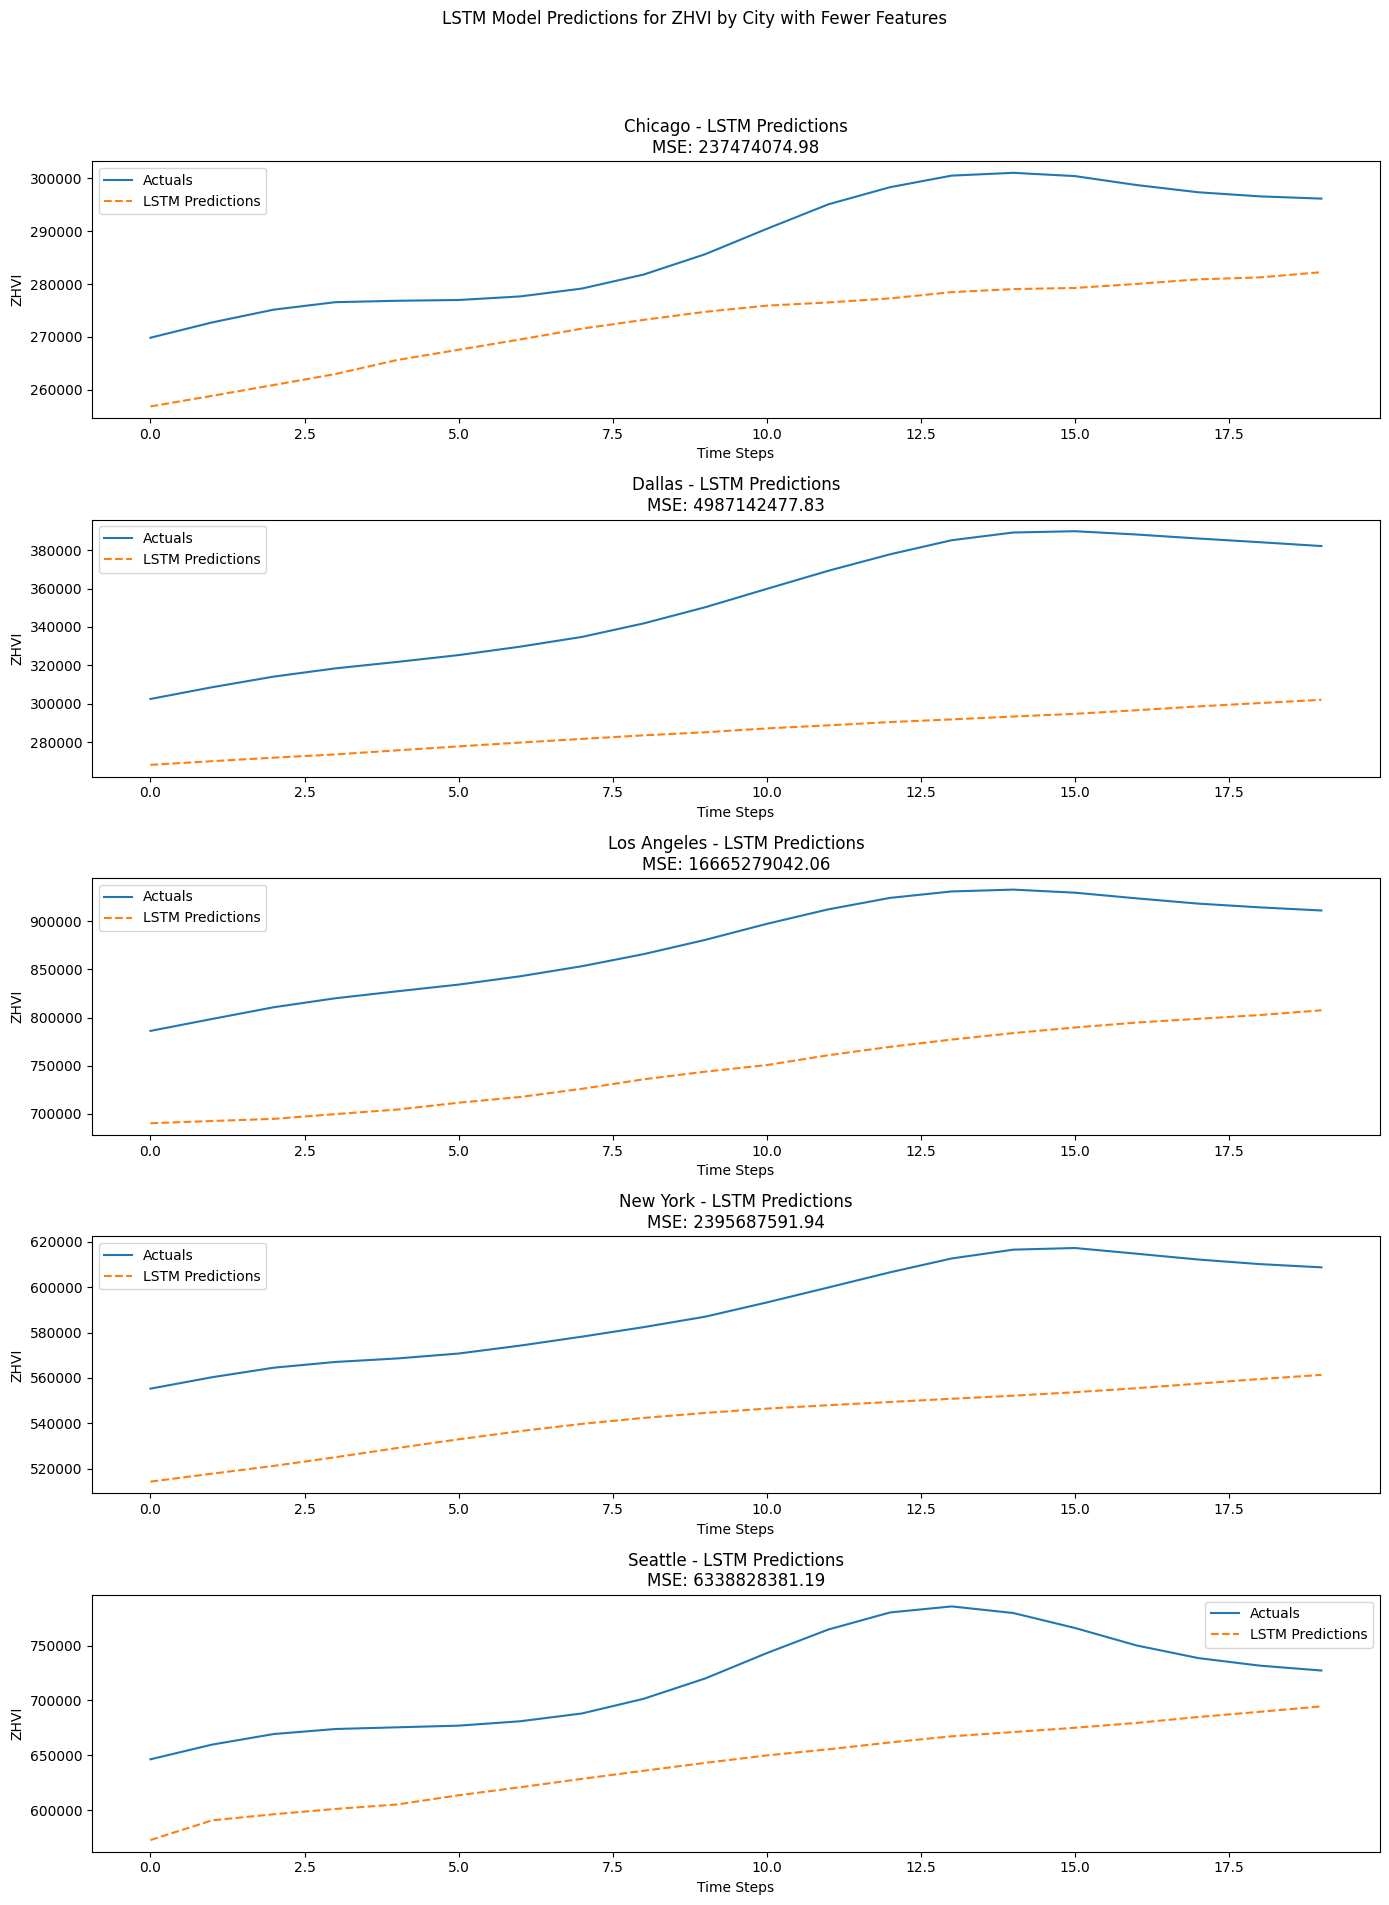

In [ ]:
# Plotting the results for each city
fig, axs = plt.subplots(len(fewer_df['City'].unique()), 1, figsize=(14, 20))
fig.suptitle('LSTM Model Predictions for ZHVI by City with Fewer Features')

for idx, city in enumerate(fewer_df['City'].unique()):
    axs[idx].plot(actual_vals[city], label='Actuals')
    axs[idx].plot(lstm_preds[city], label='LSTM Predictions', linestyle='--')
    axs[idx].set_title(f'{city} - LSTM Predictions\nMSE: {mse_results_with_fewer_features[city]:.2f}')
    axs[idx].set_xlabel('Time Steps')
    axs[idx].set_ylabel('ZHVI')
    axs[idx].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
comparison_dict = {}
for city in mse_results_with_fewer_features.keys():
  percent_change = ((mse_results_with_fewer_features[city] - mse_results_with_more_features[city])/mse_results_with_more_features[city])*100
  comparison_dict[city] = percent_change
  print(f"For {city}, the model with fewer features performed {'better' if percent_change < 0 else 'worse'} by {abs(percent_change):.2f}%")

print("\nSummary of Performance Changes:")
print(comparison_dict)

For Chicago, the model with fewer features performed better by 45.85%
For Dallas, the model with fewer features performed better by 12.44%
For Los Angeles, the model with fewer features performed better by 85.98%
For New York, the model with fewer features performed better by 70.49%
For Seattle, the model with fewer features performed better by 85.08%

Summary of Performance Changes:
{'Chicago': -45.84707113584807, 'Dallas': -12.435990583546884, 'Los Angeles': -85.97941165884153, 'New York': -70.49399798170589, 'Seattle': -85.07874530910794}


# <h1><center>Test Different Sequence Length</center></h1>

In [ ]:
# Use fewer df as we know it performs better
fewer_df = merged_df.drop(columns=['OOP_Moved_From_Different_County', 'OOP_Moved_From_Different_State',
       'OOP_Moved_From_Abroad', 'ROP_Moved_From_Different_County',
       'ROP_Moved_From_Different_State', 'ROP_Moved_From_Abroad'])

In [ ]:
# Function to preprocess data for LSTM
def preprocess_data(df, window):
    # Separate train and test data (80% train, 20% test)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    # Scale the features using MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    # Create sequences of specified length for training
    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM model
def create_and_train_lstm(X_train, y_train, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions


In [ ]:
# Define sequence lengths to test
sequence_lengths = [1, 3, 6, 9, 12, 15]

# Initialize dictionaries to store results
results = {}

# Loop through each city and each sequence length
for city in fewer_df['City'].unique():
    city_data = fewer_df[fewer_df['City'] == city].reset_index(drop=True)
    results[city] = {}

    for seq_len in sequence_lengths:
        X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=seq_len)

        # Train the model
        model = create_and_train_lstm(X_train, y_train)

        # Make predictions
        lstm_preds = make_predictions(model, X_test, scaler)
        actual_vals = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
        actual_vals = actual_vals[:, 0]

        # Calculate MSE
        mse = mean_squared_error(actual_vals, lstm_preds)
        results[city][seq_len] = {'mse': mse, 'predictions': lstm_preds, 'actuals': actual_vals}
        print(f'{city} - Sequence Length {seq_len} - MSE: {mse:.2f}')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.1668 - val_loss: 0.7709
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1531 - val_loss: 0.7128
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1360 - val_loss: 0.6500
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1068 - val_loss: 0.5846
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0957 - val_loss: 0.5160
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0790 - val_loss: 0.4428
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0675 - val_loss: 0.3726
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0571 - val_loss: 0.3082
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0545 - val_loss: 0.2693
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0553 - val_loss: 0.2533
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0535 - val_loss: 0.2380
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0535 - val_loss: 0.2249
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 346ms/step - loss: 0.1734 - val_loss: 0.7309
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1359 - val_loss: 0.5989
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0942 - val_loss: 0.4703
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0714 - val_loss: 0.3473
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0494 - val_loss: 0.2492
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0540 - val_loss: 0.1897
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0494 - val_loss: 0.1705
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0470 - val_loss: 0.1751
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0405 - val_loss: 0.1829
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0346 - val_loss: 0.1885
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0291 - val_loss: 0.1761
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0272 - val_loss: 0.1475
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.1617 - val_loss: 0.6700
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0840 - val_loss: 0.4402
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0648 - val_loss: 0.2725
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0607 - val_loss: 0.2159
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0556 - val_loss: 0.2215
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0410 - val_loss: 0.2397
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0302 - val_loss: 0.2273
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0275 - val_loss: 0.1764
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0195 - val_loss: 0.1001
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0110 - val_loss: 0.0346
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0075 - val_loss: 0.0095
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 0.1463 - val_loss: 0.2572
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0571 - val_loss: 0.1181
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0527 - val_loss: 0.1296
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0351 - val_loss: 0.1781
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0225 - val_loss: 0.1816
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0181 - val_loss: 0.1140
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0083 - val_loss: 0.0363
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0052 - val_loss: 0.0075
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0018 - val_loss: 0.0063
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - loss: 0.1678 - val_loss: 0.4037
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0718 - val_loss: 0.2109
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0864 - val_loss: 0.2359
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0491 - val_loss: 0.2905
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0390 - val_loss: 0.2918
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0324 - val_loss: 0.2241
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0188 - val_loss: 0.1222
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0091 - val_loss: 0.0492
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0080 - val_loss: 0.0271
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0028 - val_loss: 0.0146
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0039 - val_loss: 8.8542e-04
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - loss: 0.1325 - val_loss: 0.2756
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0420 - val_loss: 0.1096
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0455 - val_loss: 0.1151
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0178 - val_loss: 0.1385
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0152 - val_loss: 0.0956
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0113 - val_loss: 0.0226
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0046 - val_loss: 4.7174e-04
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0076 - val_loss: 2.8993e-04
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0027 - val_loss: 2.6682e-04
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0019 - val_loss: 8.5361

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - loss: 0.1290 - val_loss: 0.7469
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1136 - val_loss: 0.6704
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1026 - val_loss: 0.5903
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0852 - val_loss: 0.5073
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0644 - val_loss: 0.4205
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0529 - val_loss: 0.3335
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0415 - val_loss: 0.2565
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0318 - val_loss: 0.1835
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0308 - val_loss: 0.1203
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0271 - val_loss: 0.0836
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0267 - val_loss: 0.0724
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0239 - val_loss: 0.0797
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - loss: 0.1175 - val_loss: 0.5681
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0700 - val_loss: 0.3755
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0428 - val_loss: 0.2052
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0227 - val_loss: 0.0868
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0217 - val_loss: 0.0344
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0240 - val_loss: 0.0302
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0183 - val_loss: 0.0500
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0117 - val_loss: 0.0806
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0081 - val_loss: 0.0997
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0072 - val_loss: 0.0972
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0064 - val_loss: 0.0725
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0034 - val_loss: 0.0443
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.1432 - val_loss: 0.4865
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0586 - val_loss: 0.1706
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0224 - val_loss: 0.0294
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0241 - val_loss: 0.0076
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0141 - val_loss: 0.0206
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0041 - val_loss: 0.0493
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0038 - val_loss: 0.0570
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0059 - val_loss: 0.0336
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0040 - val_loss: 0.0099
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0014 - val_loss: 0.0164
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0713 - val_loss: 0.1309
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0113 - val_loss: 0.0093
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0156 - val_loss: 0.0094
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0080 - val_loss: 0.0440
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0039 - val_loss: 0.0758
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0062 - val_loss: 0.0613
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0053 - val_loss: 0.0268
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023 - val_loss: 0.0100
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0028 - val_loss: 0.0104
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0019 - val_loss: 0.0207
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0010 - val_loss: 0.0313
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0014 - val_loss: 0.0272
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.1670 - val_loss: 0.1822
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0402 - val_loss: 0.0066
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0396 - val_loss: 0.0072
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0148 - val_loss: 0.0456
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0054 - val_loss: 0.0597
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0077 - val_loss: 0.0168
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0022 - val_loss: 5.8792e-04
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0012 - val_loss: 0.0133
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0017 - val_loss: 0.0158
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0010 - val_loss: 0.0075
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - loss: 0.1921 - val_loss: 0.3079
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0425 - val_loss: 0.0262
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0294 - val_loss: 0.0033
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0179 - val_loss: 0.0258
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0036 - val_loss: 0.0717
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0077 - val_loss: 0.0698
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0078 - val_loss: 0.0317
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0038 - val_loss: 0.0090
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0034 - val_loss: 0.0066
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0026 - val_loss: 0.0165
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0012 - val_loss: 0.0332
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0015 - val_loss: 0.0393
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - loss: 0.1681 - val_loss: 0.7908
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1269 - val_loss: 0.7239
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1271 - val_loss: 0.6579
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1030 - val_loss: 0.5863
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0794 - val_loss: 0.5104
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0604 - val_loss: 0.4345
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0482 - val_loss: 0.3619
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0335 - val_loss: 0.2937
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0256 - val_loss: 0.2239
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0216 - val_loss: 0.1702
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0241 - val_loss: 0.1447
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0236 - val_loss: 0.1354
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.1332 - val_loss: 0.5764
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0755 - val_loss: 0.3924
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0379 - val_loss: 0.2345
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0229 - val_loss: 0.1225
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0227 - val_loss: 0.0826
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0293 - val_loss: 0.0921
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0225 - val_loss: 0.1283
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0167 - val_loss: 0.1706
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0152 - val_loss: 0.1971
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0155 - val_loss: 0.1997
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0140 - val_loss: 0.1837
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0121 - val_loss: 0.1528
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.1401 - val_loss: 0.5016
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0450 - val_loss: 0.2144
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0272 - val_loss: 0.0822
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0377 - val_loss: 0.0883
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0259 - val_loss: 0.1431
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0183 - val_loss: 0.2006
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0160 - val_loss: 0.2281
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0180 - val_loss: 0.2135
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0151 - val_loss: 0.1732
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0113 - val_loss: 0.1225
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0100 - val_loss: 0.0855
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0098 - val_loss: 0.0743
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - loss: 0.1728 - val_loss: 0.4156
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0344 - val_loss: 0.1401
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0246 - val_loss: 0.0507
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0368 - val_loss: 0.0682
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0274 - val_loss: 0.1349
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0159 - val_loss: 0.1959
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0164 - val_loss: 0.2201
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0187 - val_loss: 0.1950
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0145 - val_loss: 0.1498
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0117 - val_loss: 0.0982
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0086 - val_loss: 0.0675
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0090 - val_loss: 0.0625
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - loss: 0.1869 - val_loss: 0.4257
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0391 - val_loss: 0.0963
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0403 - val_loss: 0.0456
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0457 - val_loss: 0.1011
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0227 - val_loss: 0.1857
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0189 - val_loss: 0.2440
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0232 - val_loss: 0.2453
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0238 - val_loss: 0.2045
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0158 - val_loss: 0.1489
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0114 - val_loss: 0.0966
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0107 - val_loss: 0.0710
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0106 - val_loss: 0.0676
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - loss: 0.0724 - val_loss: 0.0654
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0326 - val_loss: 0.0531
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0211 - val_loss: 0.1542
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0168 - val_loss: 0.1912
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0166 - val_loss: 0.1209
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0095 - val_loss: 0.0397
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0096 - val_loss: 0.0234
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0075 - val_loss: 0.0478
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0043 - val_loss: 0.0626
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0048 - val_loss: 0.0365
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0024 - val_loss: 0.0126
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0033 - val_loss: 0.0130
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - loss: 0.0996 - val_loss: 0.6900
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0883 - val_loss: 0.6417
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0750 - val_loss: 0.5893
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0588 - val_loss: 0.5344
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0434 - val_loss: 0.4751
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0397 - val_loss: 0.4164
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0333 - val_loss: 0.3646
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0332 - val_loss: 0.3331
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0369 - val_loss: 0.3265
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0324 - val_loss: 0.3317
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0309 - val_loss: 0.3327
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0293 - val_loss: 0.3405
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.1126 - val_loss: 0.6801
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0736 - val_loss: 0.5666
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0462 - val_loss: 0.4588
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0389 - val_loss: 0.3693
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0385 - val_loss: 0.3233
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0372 - val_loss: 0.3226
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0335 - val_loss: 0.3450
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0290 - val_loss: 0.3687
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0231 - val_loss: 0.3846
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0226 - val_loss: 0.3754
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0204 - val_loss: 0.3489
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0171 - val_loss: 0.3094
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.0715 - val_loss: 0.3921
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0198 - val_loss: 0.2409
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0278 - val_loss: 0.2416
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0205 - val_loss: 0.2983
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0163 - val_loss: 0.3337
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0187 - val_loss: 0.3038
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0127 - val_loss: 0.2379
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0097 - val_loss: 0.1690
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0085 - val_loss: 0.1417
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0086 - val_loss: 0.1400
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0053 - val_loss: 0.1282
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0040 - val_loss: 0.0915
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - loss: 0.1622 - val_loss: 0.4723
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0424 - val_loss: 0.2363
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0402 - val_loss: 0.1947
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0349 - val_loss: 0.2418
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0196 - val_loss: 0.2966
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0157 - val_loss: 0.3096
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0157 - val_loss: 0.2682
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0108 - val_loss: 0.1977
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0076 - val_loss: 0.1419
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0077 - val_loss: 0.1283
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0067 - val_loss: 0.1387
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0051 - val_loss: 0.1403
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.0737 - val_loss: 0.3408
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0384 - val_loss: 0.2821
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0196 - val_loss: 0.3329
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0121 - val_loss: 0.2962
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0096 - val_loss: 0.1838
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0059 - val_loss: 0.1155
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0061 - val_loss: 0.1110
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0033 - val_loss: 0.1003
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0033 - val_loss: 0.0583
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0015 - val_loss: 0.0352
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0018 - val_loss: 0.0379
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0017 - val_loss: 0.0395
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - loss: 0.3024 - val_loss: 0.6023
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0710 - val_loss: 0.2805
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0536 - val_loss: 0.1691
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0664 - val_loss: 0.2147
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0389 - val_loss: 0.2956
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0260 - val_loss: 0.3608
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0244 - val_loss: 0.3772
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0279 - val_loss: 0.3400
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0213 - val_loss: 0.2773
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0118 - val_loss: 0.2236
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0110 - val_loss: 0.1936
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0103 - val_loss: 0.1969
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - loss: 0.1486 - val_loss: 0.7749
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1104 - val_loss: 0.7024
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1041 - val_loss: 0.6286
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0784 - val_loss: 0.5517
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0634 - val_loss: 0.4706
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0552 - val_loss: 0.3847
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0374 - val_loss: 0.3040
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0319 - val_loss: 0.2352
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0271 - val_loss: 0.1831
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0249 - val_loss: 0.1412
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0235 - val_loss: 0.1088
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0240 - val_loss: 0.1005
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - loss: 0.1132 - val_loss: 0.5672
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0649 - val_loss: 0.3768
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0338 - val_loss: 0.2109
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0223 - val_loss: 0.0937
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0237 - val_loss: 0.0469
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0283 - val_loss: 0.0522
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0220 - val_loss: 0.0810
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0147 - val_loss: 0.1124
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0144 - val_loss: 0.1334
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0133 - val_loss: 0.1363
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0127 - val_loss: 0.1158
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0108 - val_loss: 0.0839
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.1458 - val_loss: 0.5374
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0604 - val_loss: 0.2324
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0189 - val_loss: 0.0541
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0239 - val_loss: 0.0107
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0305 - val_loss: 0.0223
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0177 - val_loss: 0.0574
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0123 - val_loss: 0.0948
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0115 - val_loss: 0.1044
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0102 - val_loss: 0.0842
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0097 - val_loss: 0.0441
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0054 - val_loss: 0.0129
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 13/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 240ms/step - loss: 0.1700 - val_loss: 0.3136
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0369 - val_loss: 0.0303
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0238 - val_loss: 9.4261e-04
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0326 - val_loss: 0.0131
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0135 - val_loss: 0.0633
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0094 - val_loss: 0.1017
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0111 - val_loss: 0.0924
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0122 - val_loss: 0.0433
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0042 - val_loss: 0.0087
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0032 - val_loss: 9.3066e-04
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0028 - val_loss: 0.0023
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.1207 - val_loss: 0.2104
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0269 - val_loss: 0.0133
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0376 - val_loss: 0.0211
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0220 - val_loss: 0.0784
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0129 - val_loss: 0.1267
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0161 - val_loss: 0.1068
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0126 - val_loss: 0.0493
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0054 - val_loss: 0.0064
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0042 - val_loss: 9.9359e-04
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0043 - val_loss: 9.1747e-04
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0017 - val_loss: 0.0034
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - loss: 0.1608 - val_loss: 0.2145
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0286 - val_loss: 8.7929e-04
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0417 - val_loss: 0.0032
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0237 - val_loss: 0.0532
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0113 - val_loss: 0.1159
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0167 - val_loss: 0.1115
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0122 - val_loss: 0.0716
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0085 - val_loss: 0.0240
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0048 - val_loss: 8.8160e-04
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0020 - val_loss: 0.0085
Epo

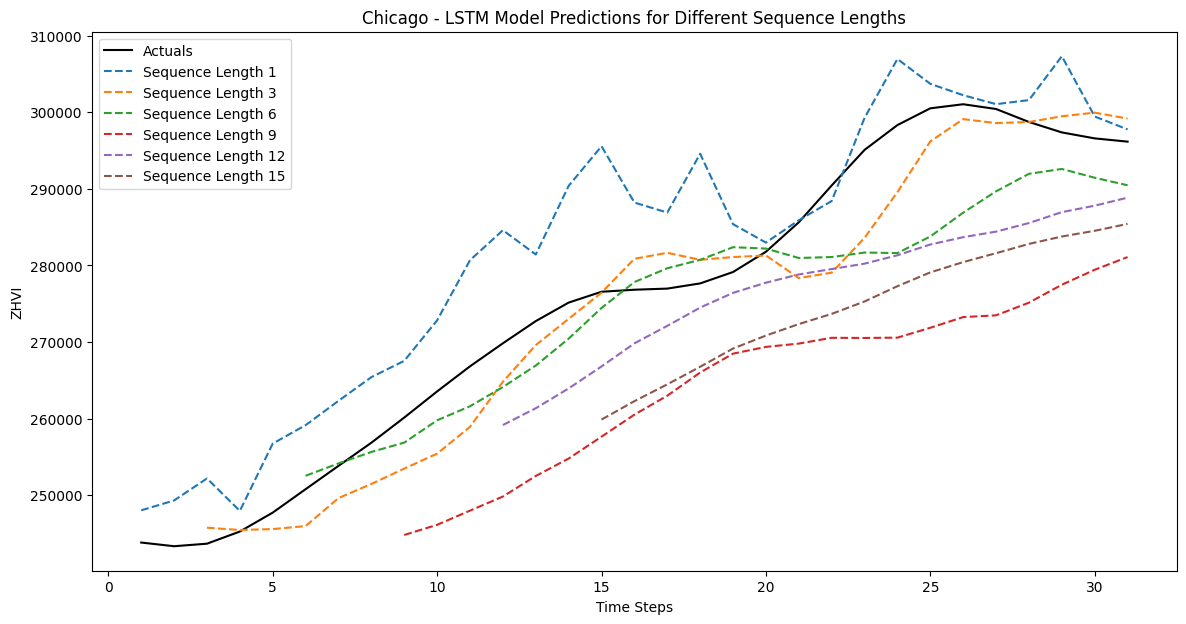

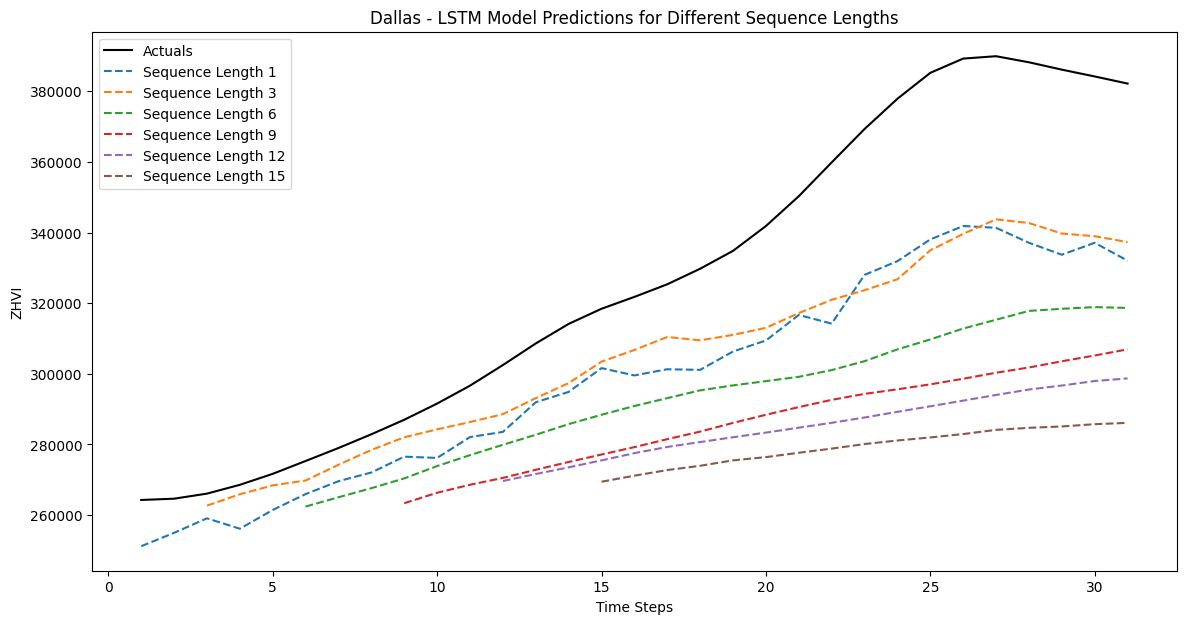

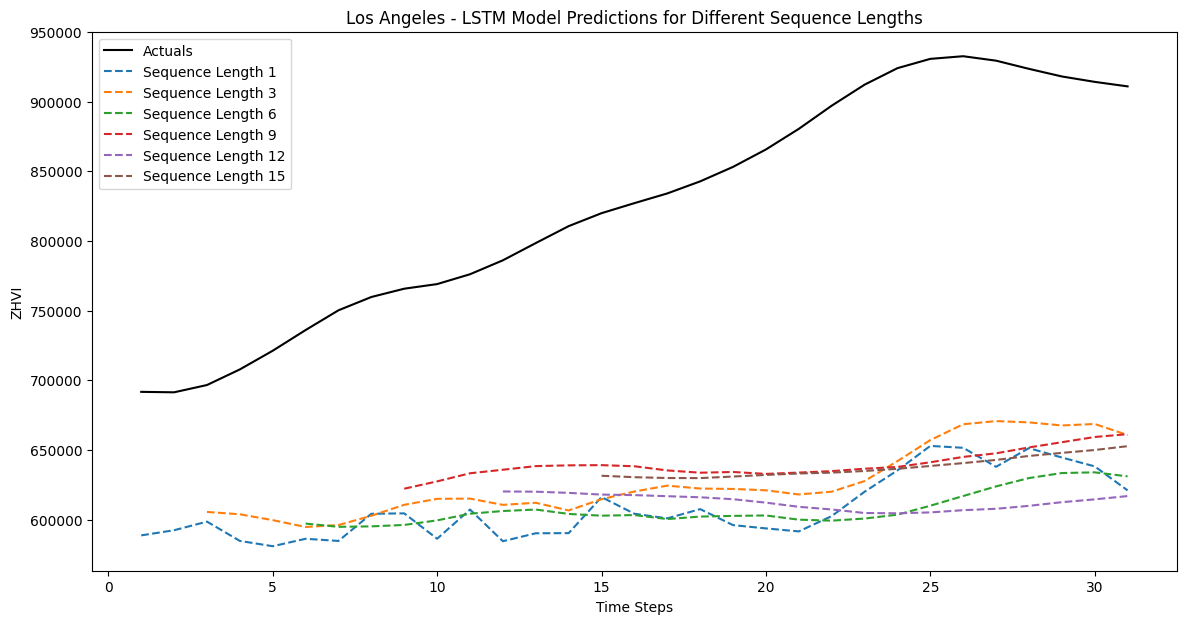

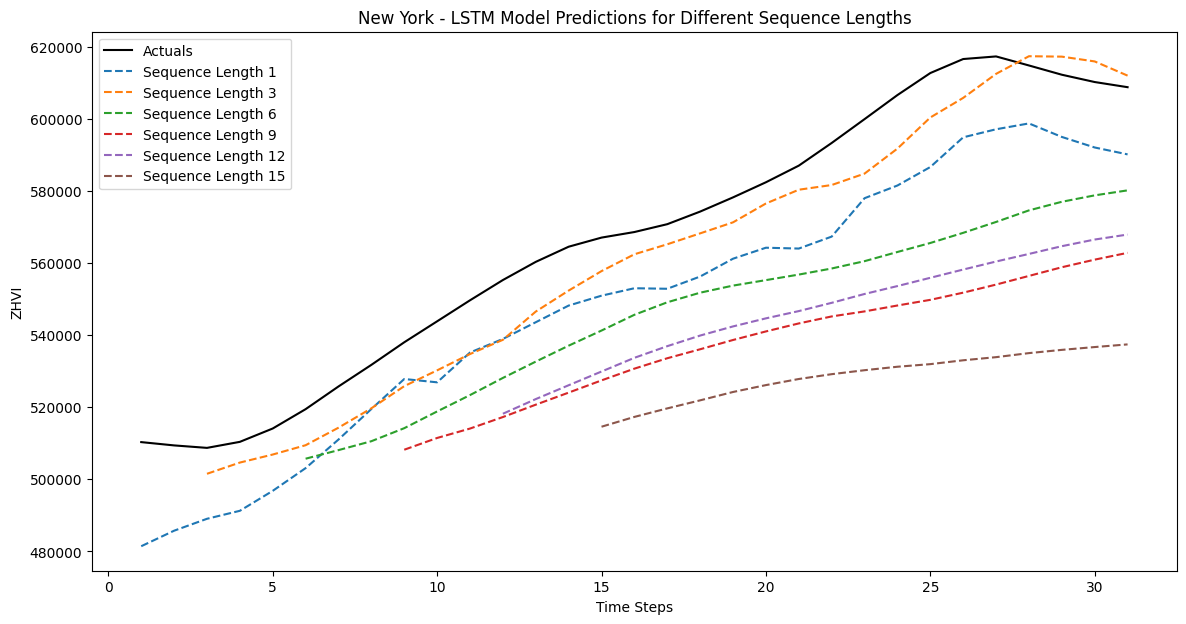

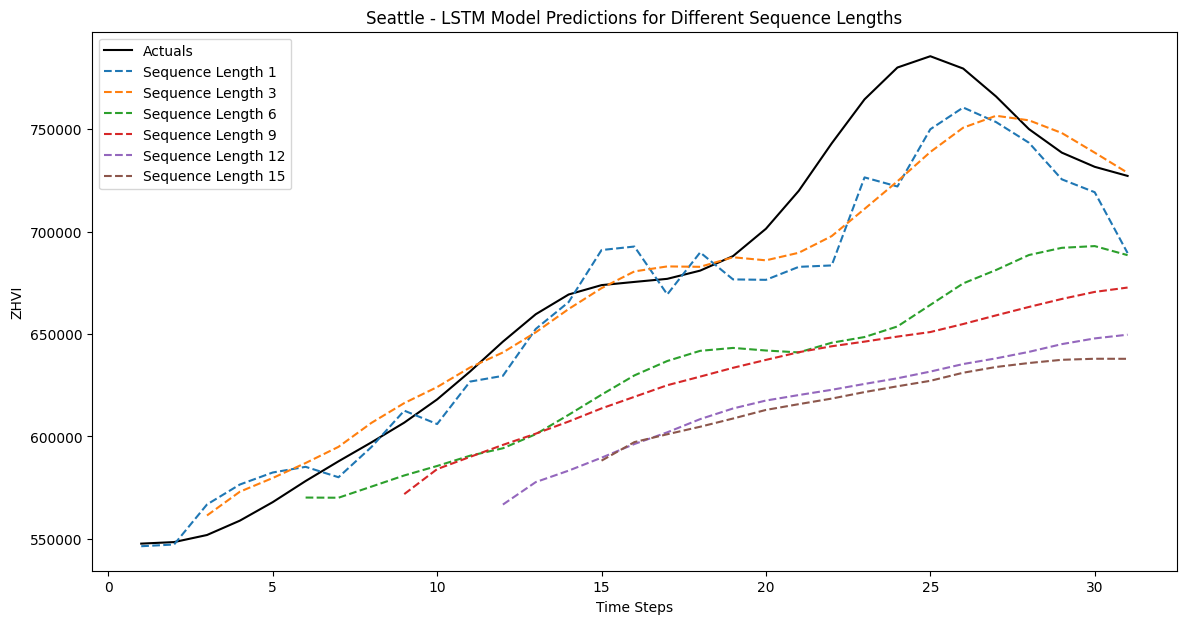

In [ ]:
# Plotting the results for each city
for city in fewer_df['City'].unique():
    plt.figure(figsize=(14, 7))
    plt.title(f'{city} - LSTM Model Predictions for Different Sequence Lengths')
    actuals_plotted = False
    for seq_len in sequence_lengths:
        if not actuals_plotted:
            plt.plot(range(seq_len, seq_len + len(results[city][seq_len]['actuals'])), results[city][seq_len]['actuals'], label='Actuals', color='black')
            actuals_plotted = True
        plt.plot(range(seq_len, seq_len + len(results[city][seq_len]['predictions'])), results[city][seq_len]['predictions'], label=f'Sequence Length {seq_len}', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('ZHVI')
    plt.legend()
    plt.show()

In [ ]:
len(results["Chicago"][3]['actuals'])

29

In [19]:
# TODO:
# Try em interpolation for better data estimation
# Add other features in
# Try out other hyper parameters